## MS Example 1

In [82]:
import numpy as np
import dfo as dfo
import ECNoise as ECN
import active_subspaces as ac
import matplotlib.pyplot as plt

We choose $\mathbf{x}^{(0)}=(100,0.1,u,u,\ldots,u)$, $u \sim U[-100,100]$.

In [83]:
dim=10
xinit=200*np.random.rand(dim)
print(np.shape(xinit))

#my nasty initial condition, but all others will plateau
xinit[0]=100
xinit[1]=.1
print(np.transpose(xinit))

(10,)
[1.00000000e+02 1.00000000e-01 9.29690335e+01 1.48354465e+02
 2.65447987e+00 7.83568491e+01 1.11028879e+02 1.32801837e+02
 2.42071065e+01 3.70302935e+01]


We let $t: \mathbf{x}: \mathbb{R}^{10} \to \mathbb{R}$, where $t(\mathbf{x})=x_1^2+x_2^2+x_3^2+ k\epsilon$, where $\epsilon \sim N(0,1)$ so that $k\epsilon \sim N(0,k^2)$ and $L_1=2$. Note if we let $x[0]=2*x[0]$ as is commented out below, we would get $L_1=8.$

In [84]:
k=1E-4
def tfun(x,var=k):
    y=np.copy(x)
    y[0]*=2
    return np.dot(y[0:3],y[0:3])+(k**.5)*np.random.randn(1)

# Print check
print(xinit)
print(tfun(xinit))
print(xinit)

[1.00000000e+02 1.00000000e-01 9.29690335e+01 1.48354465e+02
 2.65447987e+00 7.83568491e+01 1.11028879e+02 1.32801837e+02
 2.42071065e+01 3.70302935e+01]
[48643.25939316]
[1.00000000e+02 1.00000000e-01 9.29690335e+01 1.48354465e+02
 2.65447987e+00 7.83568491e+01 1.11028879e+02 1.32801837e+02
 2.42071065e+01 3.70302935e+01]


In [85]:
M=10 # number of ECNoise f evals

noise_array=ECN.ECNoise(tfun,xinit,M)
mynoise=noise_array[0][0]
gen_f_vals=noise_array[1]
print(noise_array, mynoise)
print(gen_f_vals)

48643.23611865499
48653.09773605336
48662.98106356122
48672.83867295073
48682.71919517399
48692.581742825634
48702.444698117404
48712.31851234058
48722.16674400251
48732.0607259802
[array([5.96981111e-05]), array([48643.23611865, 48653.09773605, 48662.98106356, 48672.83867295,
       48682.71919517, 48692.58174283, 48702.44469812, 48712.31851234,
       48722.166744  , 48732.06072598])] 5.969811113323144e-05
[48643.23611865 48653.09773605 48662.98106356 48672.83867295
 48682.71919517 48692.58174283 48702.44469812 48712.31851234
 48722.166744   48732.06072598]


In [86]:
print('estimated noise var is', mynoise, 'true var is', k, 'with relative error', (mynoise-k)/k)

estimated noise var is 5.969811113323144e-05 true var is 0.0001 with relative error -0.40301888866768565


In [87]:
h=1/M
fm=gen_f_vals[0]
f0=gen_f_vals[1]
fp=gen_f_vals[2]
L_1_hat=abs(fp-2*f0+fm)*(1/h)**2

d1=abs(fp-f0)*(1/h)
d2=abs(fm-f0)*(1/h)
L_1_hat_1=abs(d1-d2)*(1/h)


print('estimated upper bound on ||f''|| is', L_1_hat, 'estimated value of L_1 from FD is', L_1_hat_1)

estimated upper bound on ||f|| is 2.1710109496780206 estimated value of L_1 from FD is 2.1710109496780206


In [88]:
mu_star=dfo.get_mu_star(mynoise,L_1_hat,dim)
h=dfo.get_h(L_1_hat,dim)

In [94]:
x=np.copy(xinit)
maxit=700
xhist=np.array(x)
fhist=np.array(tfun(x))
yhist=xhist
ghist=fhist
L1Bhist=np.array(L_1_hat)
for i in range(maxit):
    #[x,f,y,fy,p,q,L1B]=dfo.STARS(x,tfun,mu_star,h)
    [x,f,y,fy]=dfo.STARS(x,tfun,mu_star,h)
    xhist=np.vstack((xhist,x))
    fhist=np.hstack((fhist,f))
    yhist=np.vstack((yhist,y))
    ghist=np.hstack((ghist,fy))
    #L1Bhist=np.vstack((L1Bhist,L1B))

In [95]:
print('our algorithm terminates with x value',np.transpose(x), 'which has f value',f)

our algorithm terminates with x value [ 3.85721585e-02 -4.84981062e-02  5.57820307e-02  1.48196326e+02
  7.07725401e+01  9.63219682e+01  9.64714510e+01  1.09199422e+02
 -2.95980496e+00  5.25736186e+01] which has f value [0.0161563]


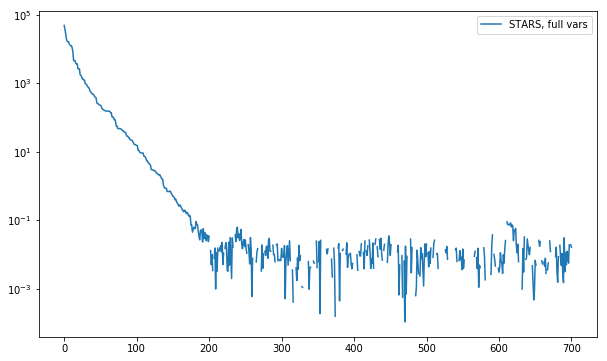

In [96]:
plt.figure(figsize=(10,6))
plt.semilogy(fhist,label='STARS, full vars')
plt.legend()
plt.show()

In [97]:
print(np.shape(xhist),np.shape(fhist),np.shape(yhist),np.shape(ghist))

(701, 10) (701,) (701, 10) (701,)


In [93]:
plt.figure(figsize=(15,10))
ss = ac.subspaces.Subspaces()
mu_star=dfo.get_mu_star(mynoise,L_1_hat,3)
h=dfo.get_h(L_1_hat,3)

for tr_stop in range(35,300,20):

    trainx=np.hstack((xhist[0:tr_stop],yhist[0:tr_stop]))
    trainf=np.vstack((fhist[0:tr_stop],ghist[0:tr_stop]))
    trainx=np.transpose(trainx)


    # Use Local Linears
    #df = ac.gradients.local_linear_gradients(x_hist, f_hist) #Estimated gradients using local linear models
    #ss.compute(df=df, nboot=0)
    
    # Use Global Quadratic
    ss.compute(X=trainx, f=trainf, nboot=0, sstype='QPHD')

    sub=ss.eigenvecs[:,0:3]
    #sub=ss.eigenvecs
 
    x4=np.transpose([xhist[:,tr_stop-1]])
    xhist4=np.array(x4)
    fhist4=np.array(tfun(x4))

    active=sub

    for i in range(0,300-tr_stop):
        [x4,f,temp,temp2,p,q,L1B]=dfo.STARS(x4,tfun,mu_star,h,active=active)
        xhist4=np.hstack((xhist4,x4))
        fhist4=np.vstack((fhist4,f))
    plt.semilogy(range(tr_stop,301),fhist4,label='train'+str(tr_stop))


plt.semilogy(fhist, label='STARS full vars')
plt.legend()
plt.show()

IndexError: too many indices for array

In [ ]:
mu_star=dfo.get_mu_star(1E-4,2,3)
h=dfo.get_h(2,3)
x3=np.copy(xinit)
xhist3=np.array(x3)
fhist3=np.array(tfun(x3))
active=np.eye(dim)
active=np.transpose(active[0:4,:])
for i in range(180):
    [x3,f,temp1,temp2, p ,q,L1B]=dfo.STARS(x3,tfun,mu_star,h,active=active)
    xhist3=np.hstack((xhist3,x3))
    fhist3=np.vstack((fhist3,f))

In [ ]:
plt.figure(figsize=(15,10))

plt.semilogy(fhist, label='STARS full vars')
plt.semilogy(fhist3, label='STARS true active vars with true hyperparams')
plt.legend()
plt.show()